In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import dates

import obspy as obs
from geopy.distance import great_circle


Bad key "text.kerning_factor" on line 4 in
C:\Users\udiyo\AppData\Local\Continuum\miniconda3\envs\uni\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Read data
[Earth quake details](https://earthquake.usgs.gov/earthquakes/eventpage/official20110311054624120_30/executive)

In [2]:
def compute_distance(x):
    
    """
    Compute distnace in km from epicenter to every station
    """
    
    station_loc = (x.latitude, x.longitude)
    
    distance = great_circle(eq_loc, station_loc).km
    
    return distance

In [3]:
# store earth quake time datetime object
eq_time = np.datetime64("2011-03-11 05:46:24")
eq_loc = (38.297, 142.373)

# read station details into a df
stations_details = pd.read_csv("obs_coord.txt", sep=" |,", engine="python", index_col=0)

# add distance column
stations_details["distance"] = stations_details.apply(compute_distance, axis=1)

# display
stations_details

,longitude,latitude,depth[m],distance
#sta,,,,
OBS03,-118.957397,33.012901,-1730.0,8473.606868
OBS06,-119.857803,32.777000,-1169.0,8422.017816
OBS16,-124.638397,34.011398,-4552.0,7981.107572
OBS18,-123.868401,33.299900,-4461.0,8084.716065


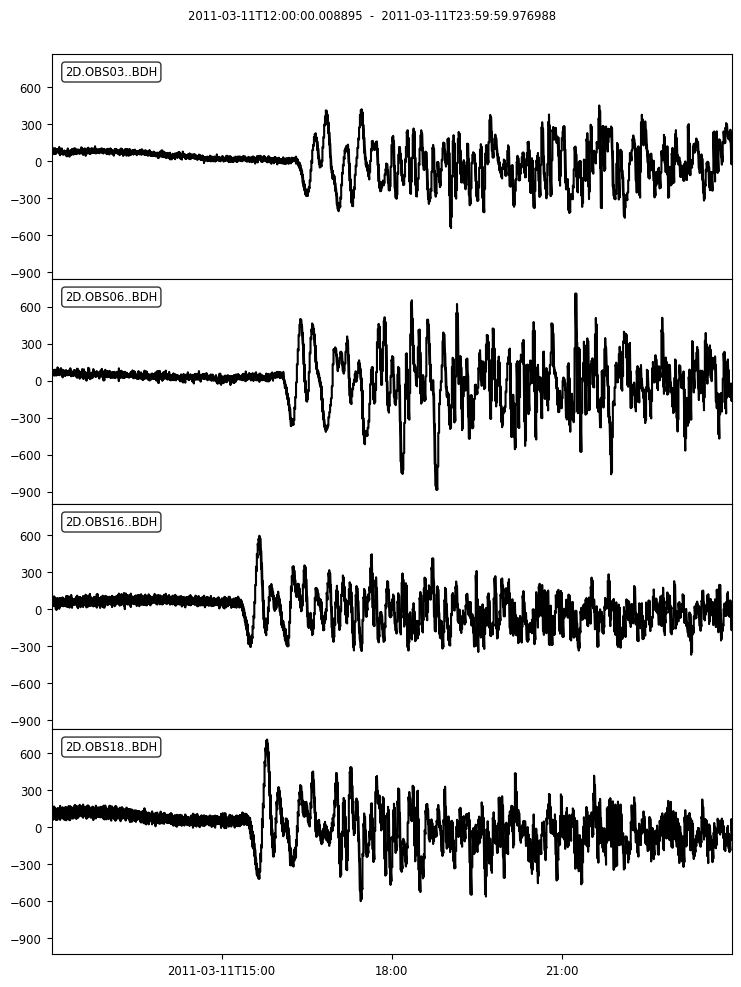

In [4]:
# read stations data into a stream object
stream = obs.read("OBS*_r.sac")

# center data by subtracting mean
stream = stream.detrend(type="demean")

# visualize data before filters
_ = stream.plot()

## Apply filters and compute envelopes

In [5]:
# period ranges in seconds
periods = np.array([(200,250), (300,350), (500,550), (720,780), (1000,1100), (1500,1700)])

filtered_streams = {}
envelopes = {}

# filter
for p in periods:
    
    key = f"{p[0]}_to_{p[1]}"
    freqmax, freqmin = 1/p
    
    # filter stream
    filtered = stream.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax)
    
    # store in filtered_streams
    filtered_streams[key] = filtered
    
    range_envelopes = {}
    
    # compute envelopes for every station after given filter
    for tr in filtered.traces:
        
        range_envelopes[tr.stats.station] = obs.signal.filter.envelope(tr.data)
    
    # store in envelopes
    envelopes[key] = range_envelopes

## Plot

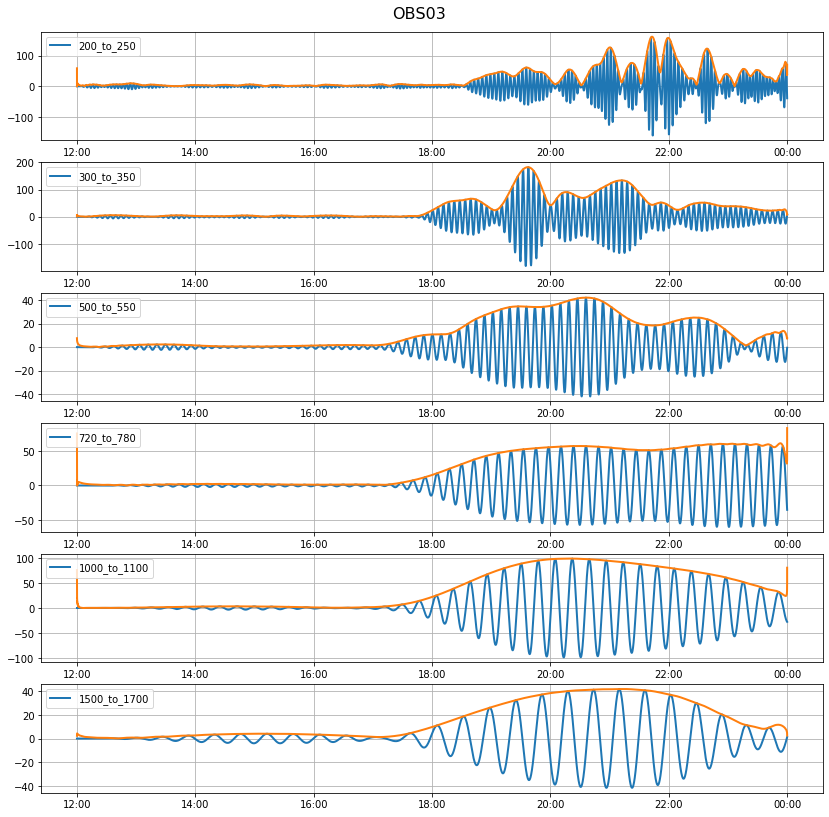

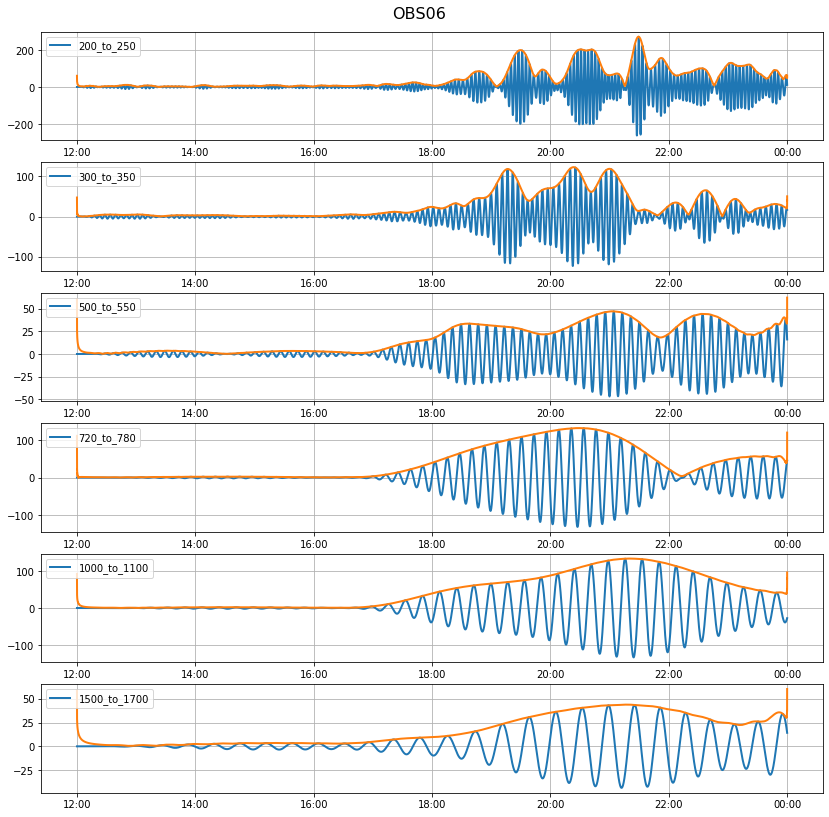

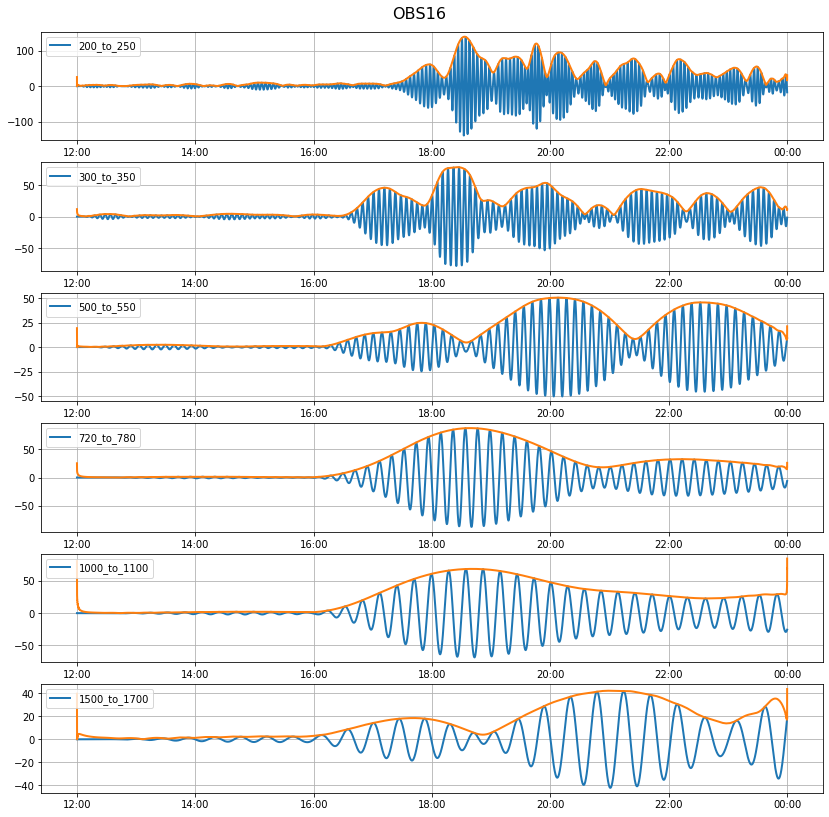

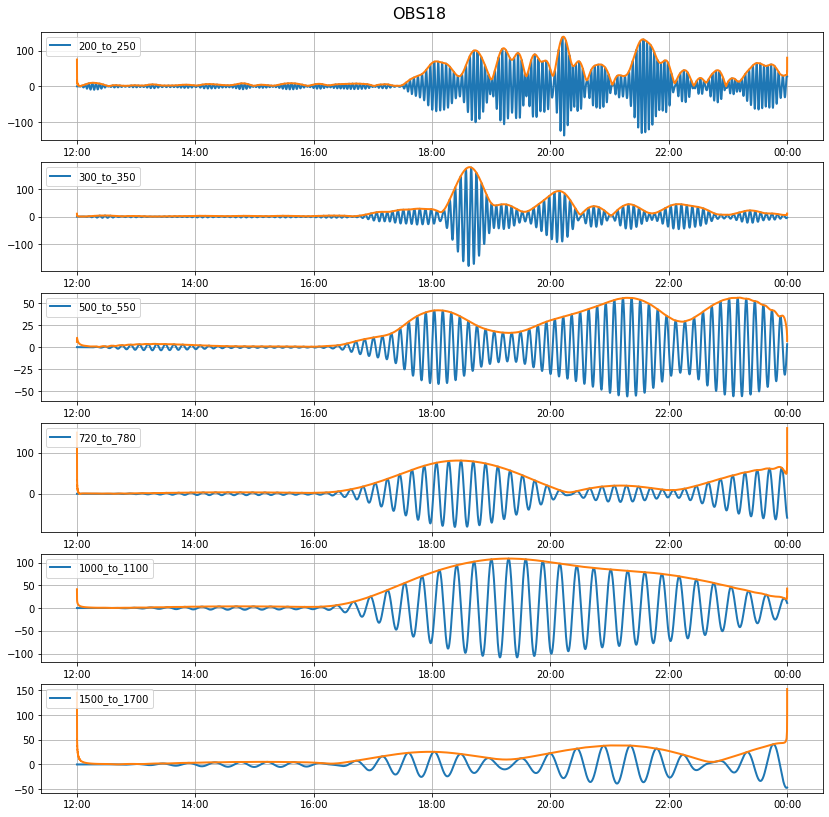

In [6]:
# iterate over stations
for i, station in enumerate(stations_details.index):
    
    fig, axes= plt.subplots(nrows=6, figsize=(14,14))
    fig.suptitle(station, y=0.905, fontsize=16)

    # iterate over filters
    for ax, key in zip(axes, filtered_streams.keys()):
        
        # get relevant trace and envelope
        tr = filtered_streams[key][i]
        env = envelopes[key][station]
    
        # build time vector
        start = np.datetime64(tr.stats.starttime)
        end = np.datetime64(tr.stats.endtime)
        dt = np.timedelta64(40,"ms")    # time delta in ms
        t = np.arange(start, end+dt, dt, dtype='datetime64[ms]')
        
        # plot
        ax.plot(t, tr, t, env, linewidth=2)
        ax.legend([key], loc="upper left")
        ax.grid()
        
        # format x axis hours and minutes
        ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))

## Q1

In [7]:
# pick one station to analyze: "OBS03"
# get distance from epicenter to station
OBS03_distnace = stations_details["distance"]["OBS03"]

# estimate arrival times from plots for OBS03 and store in a list
OBS03_arrival_times = ["19:00", "19:45", "20:45", "20:40", "20:20", "21:10"]
OBS03_arrival_times = np.array([np.datetime64(f"2011-03-11 {h}") for h in OBS03_arrival_times])

# compute travel time for every group
travel_time = np.array(OBS03_arrival_times - eq_time, dtype=np.timedelta64(1,"s")).astype(np.float32)


# store in df
idx = pd.Index(filtered_streams.keys(), name="Period range [s]")
df = pd.DataFrame({"arrival times": OBS03_arrival_times, "travel time": travel_time}, index=idx)
df["Velocity [km/s]"] = OBS03_distnace / df["travel time"]

df

,arrival times,travel time,Velocity [km/s]
Period range [s],,,
200_to_250,2011-03-11 19:00:00,47616.0,0.177957
300_to_350,2011-03-11 19:45:00,50316.0,0.168408
500_to_550,2011-03-11 20:45:00,53916.0,0.157163
720_to_780,2011-03-11 20:40:00,53616.0,0.158042
1000_to_1100,2011-03-11 20:20:00,52416.0,0.161661
1500_to_1700,2011-03-11 21:10:00,55416.0,0.152909


## Q2

### Shallow stations

In [8]:
# compute distances diff between shallow stations
shallow_dis = np.abs(stations_details["distance"]["OBS03"] - stations_details["distance"]["OBS06"])

# estimate arrival times for OBS06
OBS06_arrival_times = ["18:50", "19:05", "21:00", "20:45", "21:40", "21:20"]
OBS06_arrival_times = np.array([np.datetime64(f"2011-03-11 {h}") for h in OBS06_arrival_times])

# store data in df
shallow_df = pd.DataFrame(np.stack([OBS03_arrival_times, OBS06_arrival_times]).T, columns=["OBS03", "OBS06"], index=idx)

# compute time offset between arrival times in the stations
shallow_df["time offset"] = ((shallow_df["OBS03"] - shallow_df["OBS06"])).astype(np.timedelta64(1,"s")).abs()

# compute velocity
shallow_df["Velocity [km/s]"] = (shallow_dis / shallow_df["time offset"])

# display
shallow_df

,OBS03,OBS06,time offset,Velocity [km/s]
Period range [s],,,,
200_to_250,2011-03-11 19:00:00,2011-03-11 18:50:00,600.0,0.085982
300_to_350,2011-03-11 19:45:00,2011-03-11 19:05:00,2400.0,0.021495
500_to_550,2011-03-11 20:45:00,2011-03-11 21:00:00,900.0,0.057321
720_to_780,2011-03-11 20:40:00,2011-03-11 20:45:00,300.0,0.171964
1000_to_1100,2011-03-11 20:20:00,2011-03-11 21:40:00,4800.0,0.010748
1500_to_1700,2011-03-11 21:10:00,2011-03-11 21:20:00,600.0,0.085982


### Deep stations

In [9]:
# compute distances diff between deep stations
deep_dis = np.abs(stations_details["distance"]["OBS16"] - stations_details["distance"]["OBS18"])

# estimate arrival times
OBS16_arrival_times = ["18:00", "17:10", "17:50", "18:45", "18:40", "17:40"]
OBS16_arrival_times = np.array([np.datetime64(f"2011-03-11 {h}") for h in OBS16_arrival_times])

OBS18_arrival_times = ["18:10", "18:30", "18:05", "18:30", "19:00", "18:00"]
OBS18_arrival_times = np.array([np.datetime64(f"2011-03-11 {h}") for h in OBS18_arrival_times])

# store data in df
deep_df = pd.DataFrame(np.stack([OBS16_arrival_times, OBS18_arrival_times]).T, columns=["OBS16", "OBS18"], index=idx)

# compute time offset between arrival times in the stations
deep_df["time offset"] = ((deep_df["OBS16"] - deep_df["OBS18"])).astype(np.timedelta64(1,"s")).abs()

# compute velocity
deep_df["Velocity [km/s]"] = (deep_dis / deep_df["time offset"])

# display
deep_df

,OBS16,OBS18,time offset,Velocity [km/s]
Period range [s],,,,
200_to_250,2011-03-11 18:00:00,2011-03-11 18:10:00,600.0,0.172681
300_to_350,2011-03-11 17:10:00,2011-03-11 18:30:00,4800.0,0.021585
500_to_550,2011-03-11 17:50:00,2011-03-11 18:05:00,900.0,0.115121
720_to_780,2011-03-11 18:45:00,2011-03-11 18:30:00,900.0,0.115121
1000_to_1100,2011-03-11 18:40:00,2011-03-11 19:00:00,1200.0,0.086340
1500_to_1700,2011-03-11 17:40:00,2011-03-11 18:00:00,1200.0,0.086340


### Velocities comparison

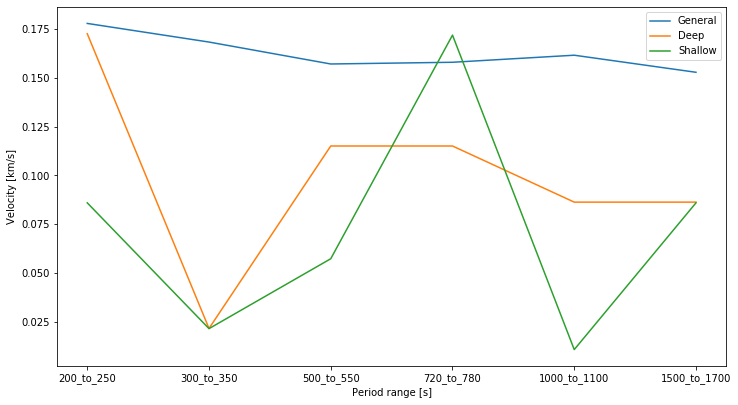

In [10]:
velocities = pd.concat([df["Velocity [km/s]"], deep_df["Velocity [km/s]"], shallow_df["Velocity [km/s]"]], 
          axis=1, keys=["General", "Deep", "Shallow"])

# plot
velocities.plot(figsize=(12,6.6))
plt.ylabel("Velocity [km/s]")
plt.show()

### Amplitude analysis

In [11]:
station1 = "OBS03"
station2 = "OBS18"
range1 = "300_to_350"
range2 = "1500_to_1700"

In [12]:
# store envelopes for relevant stations and ranges in a df
env_df = pd.concat([
    pd.DataFrame(envelopes[range1])[[station1, station2]],
    pd.DataFrame(envelopes[range2])[[station1, station2]]
], axis=1, keys=[range1, range2])


env_df.index = t
env_df

300_to_350            1500_to_1700            
                             OBS03      OBS18        OBS03       OBS18
2011-03-11 12:00:00.010   4.761928  10.786590     2.301645  145.295288
2011-03-11 12:00:00.050   0.540569   8.644110     3.070127  115.448018
2011-03-11 12:00:00.090   0.577719   8.639016     3.065182  115.449049
2011-03-11 12:00:00.130   0.808555   7.922162     3.318489  105.500874
2011-03-11 12:00:00.170   0.775325   7.917766     3.313987  105.502132
...                            ...        ...          ...         ...
2011-03-11 23:59:59.810   6.709728   8.649472     3.569893  115.444991
2011-03-11 23:59:59.850   6.722493   8.644162     3.566365  115.445720
2011-03-11 23:59:59.890   6.662501   9.298552     3.321115  124.603659
2011-03-11 23:59:59.930   6.683101   9.292616     3.317274  124.604215
2011-03-11 23:59:59.970   8.182826  11.303904     2.608154  152.672466

[1080000 rows x 4 columns]

In [13]:
# find maximum value near estimated first arrival time
# 300_to_350
amp03_1 = env_df[range1][station1]["2011-03-11 19:38"].max()
amp18_1 = env_df[range1][station2]["2011-03-11 18:37"].max()

# 1500_to_1700
amp03_2 = env_df[range2][station1]["2011-03-11 21:14"].max()
amp18_2 = env_df[range2][station2]["2011-03-11 17:57"].max()

In [14]:
# store amplitdues in a df for plotting
amp_df = pd.DataFrame(np.array([amp18_1, amp03_1, amp18_2, amp03_2]).reshape(2,2))
amp_df.columns = pd.Index([station2, station1], name="Stations")
amp_df.index = pd.Index([range1, range2], name="Period range")
amp_df

Stations,OBS18,OBS03
Period range,,
300_to_350,180.983245,182.516815
1500_to_1700,25.573967,41.827879


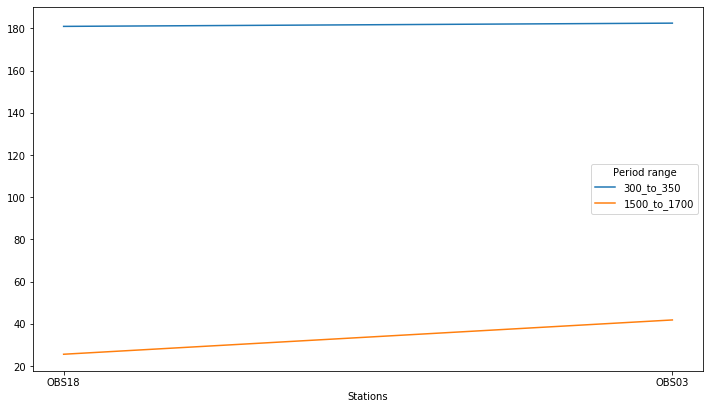

In [15]:
# plot
amp_df.T.plot(figsize=(12,6.7))
plt.xticks([0,1], [station2, station1])
plt.show()